In [4]:
import numpy as np
import csv
# from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from model import Network, SimpleNET, ResNet
    
from augmentation import transforms_0
from train import train
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
BATCH_SIZE = 64
trainset = datasets.ImageFolder('/dtu/datasets1/02514/hotdog_nothotdog/train', transform=transforms_0)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

testset = datasets.ImageFolder('/dtu/datasets1/02514/hotdog_nothotdog/test', transform=transforms_0)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [5]:
test_classes = [re.split("/| ", c)[-2] for c, _ in testset.imgs]
classes = set([re.split("/| ", c)[-2] for c, _ in testset.imgs])

### Train the model (to be replaced with loading the model)

In [7]:
transfer_model = torch.load('models/resnet50_head_ADAMW')

In [25]:
custom_model = ResNet(4, 4).to(device)
custom_model.load_state_dict(torch.load('results/final_model_weights'))

<All keys matched successfully>

In [21]:
MODEL_NAME = 'ResNet'
if MODEL_NAME == 'ResNet':
    from config.ResNet_config import *
else:
    from config.baseline_config import *

In [22]:
if MODEL_NAME == 'ResNet':
    model = eval(MODEL_NAME)(n_features=CONV_SIZE, num_res_blocks=NUM_BLOCKS)
else:
    model = eval(MODEL_NAME)()
    
model.to(device)
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # , weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=DECAY_RATE)

In [23]:
out_dict_adam = train(model, train_loader, test_loader, loss, optimizer, NUM_EPOCHS)

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.702	 test: 0.679	 Accuracy train: 52.7%	 test: 53.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.650	 test: 0.615	 Accuracy train: 62.9%	 test: 69.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.594	 test: 0.563	 Accuracy train: 69.8%	 test: 72.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.549	 test: 0.590	 Accuracy train: 73.8%	 test: 69.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.539	 test: 0.550	 Accuracy train: 75.2%	 test: 72.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.530	 test: 0.543	 Accuracy train: 75.1%	 test: 73.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.514	 test: 0.547	 Accuracy train: 76.6%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.500	 test: 0.543	 Accuracy train: 77.3%	 test: 73.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.484	 test: 0.541	 Accuracy train: 78.4%	 test: 72.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.475	 test: 0.538	 Accuracy train: 78.8%	 test: 73.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.455	 test: 0.603	 Accuracy train: 79.3%	 test: 69.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.446	 test: 0.539	 Accuracy train: 80.3%	 test: 72.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.422	 test: 0.557	 Accuracy train: 82.5%	 test: 72.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.410	 test: 0.546	 Accuracy train: 82.4%	 test: 73.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.372	 test: 0.564	 Accuracy train: 84.3%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.408	 test: 0.630	 Accuracy train: 81.6%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.292	 test: 0.597	 Accuracy train: 88.6%	 test: 72.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.240	 test: 0.580	 Accuracy train: 91.0%	 test: 72.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.182	 test: 0.657	 Accuracy train: 94.2%	 test: 72.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.142	 test: 0.592	 Accuracy train: 96.4%	 test: 73.1%


### Get misclassifications

In [32]:
transfer_outputs = None
transfer_targets = None
custom_outputs = None
custom_targets = None

for data, target in test_loader:
    data = data.to(device)
    with torch.no_grad():
        transfer_output = transfer_model(data)
        custom_output = custom_model(data)
        
    if transfer_outputs is None:
        transfer_outputs = transfer_output
        custom_outputs = custom_output
        transfer_targets = target
        custom_targets = target
    else:
        transfer_outputs = torch.cat((transfer_outputs, transfer_output))
        transfer_targets = torch.cat((transfer_targets, target))
        custom_outputs = torch.cat((custom_outputs, custom_output))
        custom_targets = torch.cat((custom_targets, target))

In [35]:
transfer_predicted = (transfer_outputs > 0.5).type(torch.IntTensor)[:, 0]
custom_predicted = (custom_outputs > 0.5).type(torch.IntTensor)[:, 0]
transfer_acc = dict([(c, 0.) for c in classes])
custom_acc = dict([(c, 0.) for c in classes])
for c in classes:
    transfer_acc[c] = ((transfer_predicted == transfer_targets) * (np.array(test_classes) == c)).sum().float() / ((np.array(test_classes) == c).sum()).astype(float)
    custom_acc[c] = ((custom_predicted == custom_targets) * (np.array(test_classes) == c)).sum().float() / ((np.array(test_classes) == c).sum()).astype(float)

In [36]:
transfer_acc

{'pets': tensor(0.9943),
 'furniture': tensor(0.9677),
 'chilidog': tensor(0.9513),
 'hotdog': tensor(0.9709),
 'food': tensor(0.8830),
 'people': tensor(0.9845),
 'frankfurter': tensor(0.9342)}

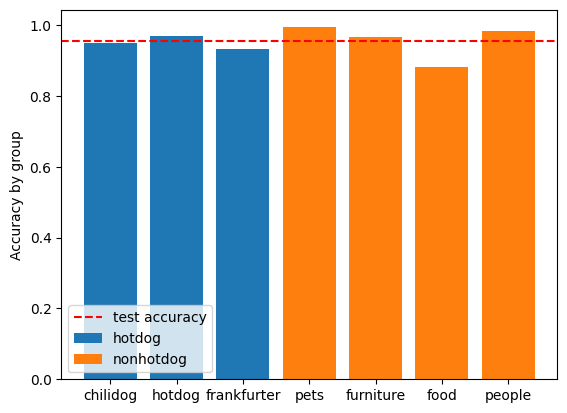

In [64]:
acc = (transfer_predicted == transfer_targets).sum().float() / float(len(transfer_predicted))

keys = list(transfer_acc.keys())
values = list(transfer_acc.values())
hotdog_keys = [keys[i] for i in [2, 3, 6]]
nonhotdog_keys = [keys[i] for i in [0, 1, 4, 5]]
hotdog_values = [values[i] for i in [2, 3, 6]]
nonhotdog_values = [values[i] for i in [0, 1, 4, 5]]

plt.bar(hotdog_keys, hotdog_values, label='hotdog')
plt.bar(nonhotdog_keys, nonhotdog_values, label='nonhotdog')
plt.axhline(y=acc, color='r', linestyle='--', label='test accuracy')
plt.ylabel('Accuracy by group')
plt.legend()
plt.show()

In [65]:
acc

tensor(0.9565)

In [37]:
custom_acc

{'pets': tensor(0.3761),
 'furniture': tensor(0.4409),
 'chilidog': tensor(0.5942),
 'hotdog': tensor(0.6017),
 'food': tensor(0.3585),
 'people': tensor(0.3178),
 'frankfurter': tensor(0.5885)}